In [1]:
library("openxlsx")

Warning message:
“package ‘openxlsx’ was built under R version 3.6.3”

In [2]:
df <- read.xlsx("АнализКровиNA.xlsx", sheet = 11)

In [3]:
# если пропуски 
any(is.na(df))

[1] TRUE

In [4]:
str(df)

'data.frame':	133 obs. of  11 variables:
 $ sirname: chr  "Allen" "Arnold" "Arnold" "Baker" ...
 $ age    : num  38 29 43 34 19 50 45 32 63 38 ...
 $ gender : chr  "female" "male" "female" "female" ...
 $ WBC    : num  8.6 7.3 7.5 6.8 7.4 7.3 5.2 12.5 7.6 4 ...
 $ RBC    : num  4.3 4.3 6 7.1 NA 6.5 6.4 4.5 5.7 3.8 ...
 $ HGB    : num  111 127 148 171 122 163 169 134 167 121 ...
 $ HCT    : num  0.25 0.46 0.47 0.55 NA 0.53 0.46 0.41 0.49 0.48 ...
 $ PLT    : num  256 245 189 211 221 226 254 362 280 228 ...
 $ LYM    : num  NA 1.8 2.2 2.8 1.6 2.8 1.9 3.7 NA 0.9 ...
 $ MCV    : num  73 88 88 88 95 83 86 89 NA 101 ...
 $ Type   : chr  "Anemia" "Healthy" "Thrombosis" "Thrombosis" ...


In [7]:
# Используем функцию complete.cases() для получения процента отсутствующих значений
mean(!complete.cases(df))*100

[1] 8.270677

In [10]:
# функция производит замену пропусков
# type может быть  median, mean, min
impute <- function(data, type) {
  for (i in which(sapply(data, is.numeric))) {
    data[is.na(data[, i]), i] <- type(data[, i],  na.rm = TRUE)
  }
  return(data)}

df2 <- impute(df, median)

In [11]:
# остались ли пропуски 
any(is.na(df2))

[1] FALSE

# Названия анализов 

In [12]:
nums <- unlist(lapply(df2, is.numeric))  

In [13]:
list_names <- colnames(df2[ , nums])[colnames(df2[ , nums]) != "age"]

In [14]:
list_names

[1] "WBC" "RBC" "HGB" "HCT" "PLT" "LYM" "MCV"

# загрузим данные с нормами 

In [15]:
normq <- read.xlsx("АнализКровиNA.xlsx", sheet = 3)

In [16]:
colnames(normq)[colnames(normq) == "X1"] <- "gender"

In [17]:
normq

gender,WBC,RBC,PLT,LYM,GRA,MCV,MCH,HGB,HCT
male,4,4.3,180,1.2,1.2,80,26,120,0.39
female,4,3.8,180,1.2,1.2,80,26,120,0.35
male,9,6.2,320,3.0,6.1,100,35,140,0.49
female,9,5.5,320,3.0,6.1,100,35,140,0.45


# функция которая вычисляет для каждого пациента и каждого анализа вычислите, выше он нормы, ниже или в пределах

In [14]:
f <- function(df_dan, df_norm){
    nums <- sapply(df_dan, is.numeric)
    list_names <- colnames(df_dan[ , nums])[colnames(df_dan[ , nums]) != "age"]
    list_normq <- colnames(df_norm)[colnames(df_norm) %in% list_names]

    men <- subset(df_dan, gender == 'male')
    women <- subset(df_dan, gender == 'female')

    y_m <- df_norm[c(1, 3),]
    y_w <- df_norm[c(2, 4),]

    for(r in 1:nrow(men)){
        for(c in list_normq){
            if(men[r, c] >= y_m[1, c] && men[r, c] < y_m[2, c]){
                men[r, c] <- 'mid'
            }else if(men[r, c] < y_m[1, c]){
                    men[r, c] <- 'low'
            }else if(men[r, c] >= y_m[2, c]){
                     men[r, c] <- 'hi'
            }
        }
    }

    for(r in 1:nrow(women)){
        for(c in list_normq){
            if(women[r, c] >= y_w[1, c] && women[r, c] < y_w[2, c] ){
                women[r, c] <- 'mid'
            }else if(women[r, c] < y_w[1, c]){
                    women[r, c] <- 'low'
            }else if(women[r, c] >= y_w[2, c]){
                     women[r, c] <- 'hi'
            }
        }
    }    
    res <- rbind(men, women)
        
    for(c in list_normq){
    res[, c] <- as.factor(res[, c])
}    
    return(res)
}

In [18]:
#то что было на уроке 
ff <- function(df_dan, df_norm){
    
    cut(df_dan[, 1], c(0, df_norm[, names(df_dan)], Inf), labels=c('low', 'norm', 'high'))
}

In [19]:
ress <- ff(df2, normq)

ERROR: Error in cut.default(df_dan[, 1], c(0, df_norm[, names(df_dan)], Inf), : 'x' must be numeric


In [15]:
res <- f(df2, normq)

In [16]:
str(res)

'data.frame':	133 obs. of  11 variables:
 $ sirname: chr  "Arnold" "Bishop" "Byrne" "Byrne" ...
 $ age    : num  29 50 38 72 37 38 40 60 47 66 ...
 $ gender : chr  "male" "male" "male" "male" ...
 $ WBC    : Factor w/ 3 levels "hi","low","mid": 3 3 3 3 3 1 2 3 3 3 ...
 $ RBC    : Factor w/ 3 levels "hi","low","mid": 3 1 2 1 2 3 2 3 3 3 ...
 $ HGB    : Factor w/ 3 levels "hi","low","mid": 3 1 3 1 2 3 3 3 3 1 ...
 $ HCT    : Factor w/ 3 levels "hi","low","mid": 3 1 3 1 2 2 3 2 3 1 ...
 $ PLT    : Factor w/ 2 levels "hi","mid": 2 2 2 2 2 2 1 2 2 2 ...
 $ LYM    : Factor w/ 3 levels "hi","low","mid": 3 3 2 3 3 3 1 3 3 3 ...
 $ MCV    : Factor w/ 3 levels "hi","low","mid": 3 1 2 1 2 1 1 1 1 1 ...
 $ Type   : chr  "Healthy" "Thrombosis" "Deficit" "Thrombosis" ...


напишем общую функцию для проверки критериев 

In [17]:
prov <- function(x, y, test, res=c("Отвергаем H_0","Принимаем H_0"), alfa=0.05) {
    test(x,y)-> test_xy
    cat("Проверяется",test_xy$method,"\n")
    cat("На уровне",format(test_xy$p.value,dig=2),
        res[1+(test_xy$p.value>alfa)],"\n")
}

# Проверим, есть ли взаимосвязь данных с диагнозом ( с помощью критерия хи-квадрат)

In [18]:
x<- as.factor(res$Type)
for(z in list_names){
    cat(z)
    prov(x, res[, z], chisq.test)
    cat('-------------------------------------\n')
}


WBC

Warning message in test(x, y):
“Chi-squared approximation may be incorrect”

Проверяется Pearson's Chi-squared test 
На уровне 1.1e-20 Отвергаем H_0 
-------------------------------------
RBC

Warning message in test(x, y):
“Chi-squared approximation may be incorrect”

Проверяется Pearson's Chi-squared test 
На уровне 1.6e-26 Отвергаем H_0 
-------------------------------------
HGB

Warning message in test(x, y):
“Chi-squared approximation may be incorrect”

Проверяется Pearson's Chi-squared test 
На уровне 3.9e-41 Отвергаем H_0 
-------------------------------------
HCT

Warning message in test(x, y):
“Chi-squared approximation may be incorrect”

Проверяется Pearson's Chi-squared test 
На уровне 6e-42 Отвергаем H_0 
-------------------------------------
PLT

Warning message in test(x, y):
“Chi-squared approximation may be incorrect”

Проверяется Pearson's Chi-squared test 
На уровне 8.9e-28 Отвергаем H_0 
-------------------------------------
LYM

Warning message in test(x, y):
“Chi-squared approximation may be incorrect”

Проверяется Pearson's Chi-squared test 
На уровне 8.7e-48 Отвергаем H_0 
-------------------------------------
MCV

Warning message in test(x, y):
“Chi-squared approximation may be incorrect”

Проверяется Pearson's Chi-squared test 
На уровне 1.4e-13 Отвергаем H_0 
-------------------------------------


# Графики

Warning message in chisq.test(df2$Type, df2[, nnn]):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(df2$Type, df2[, nnn]):
“Chi-squared approximation may be incorrect”

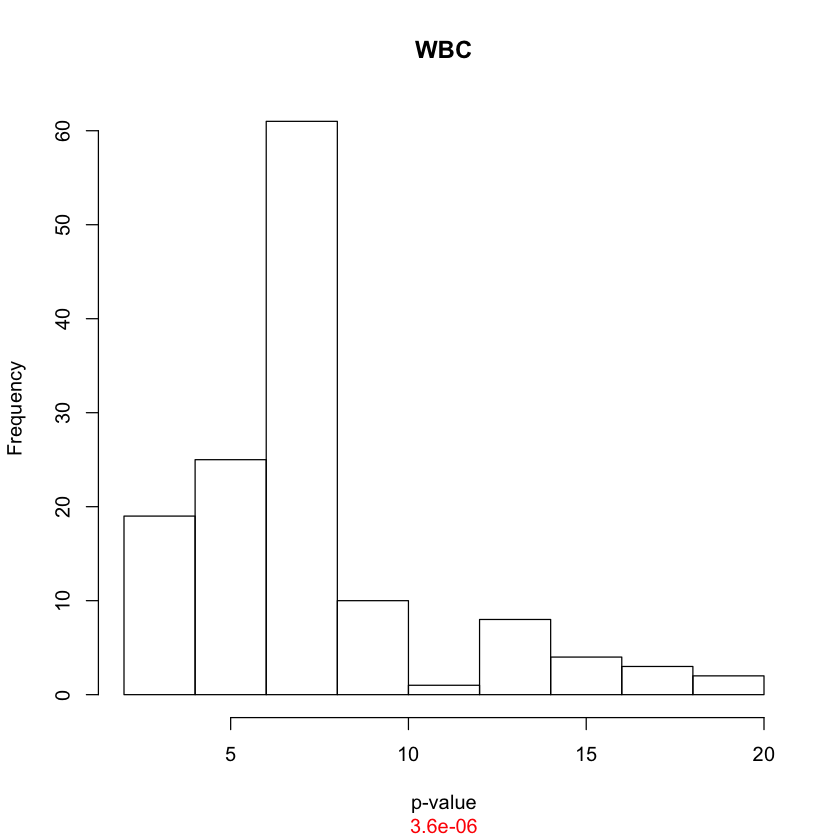

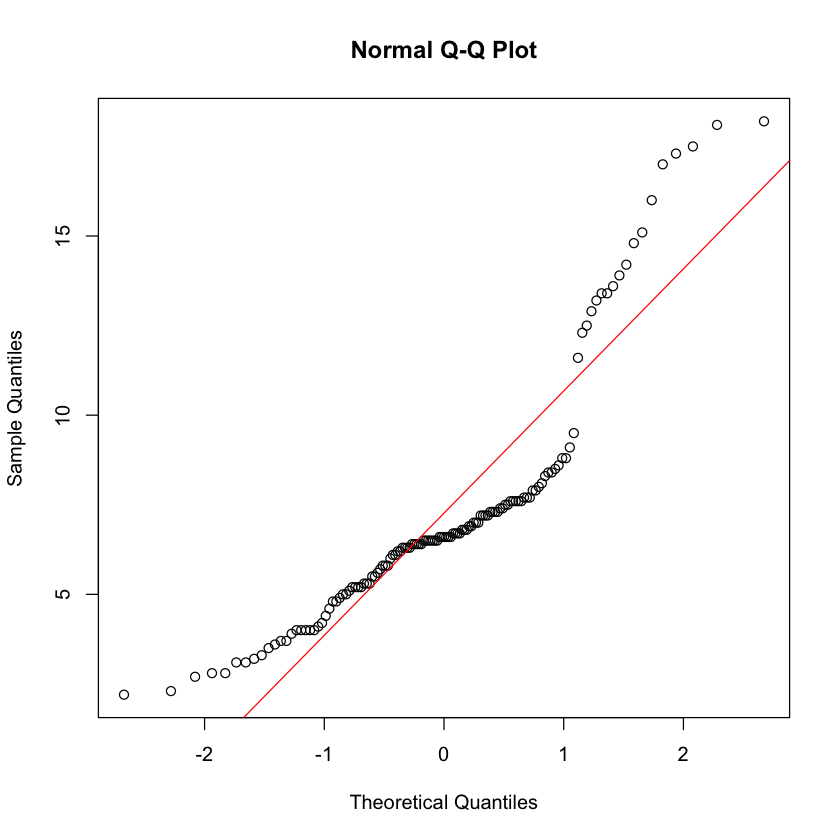

Warning message in chisq.test(df2$Type, df2[, nnn]):
“Chi-squared approximation may be incorrect”

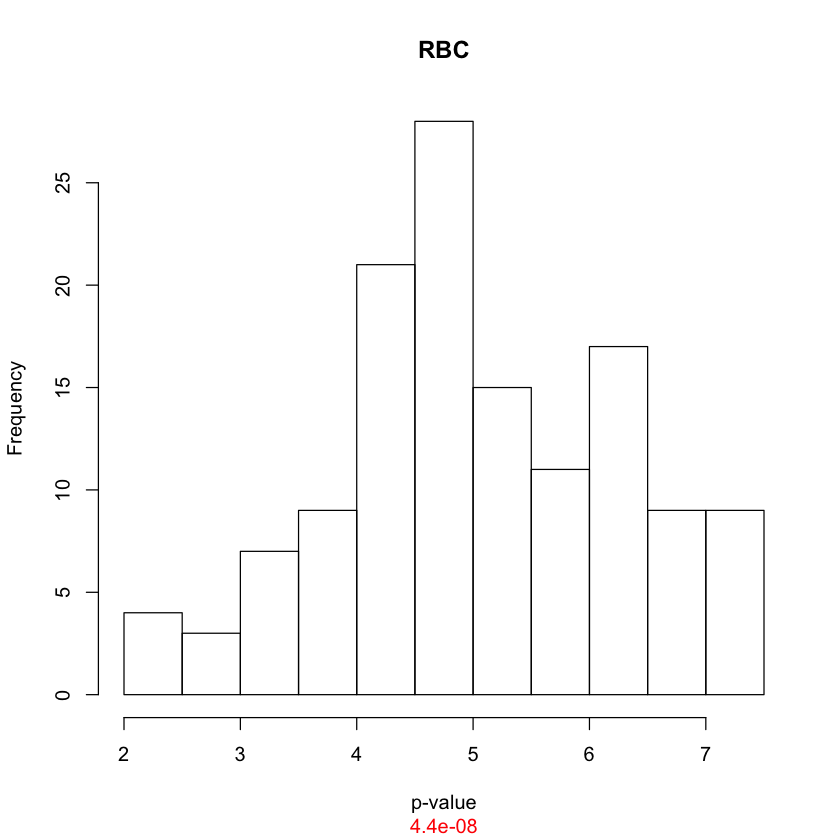

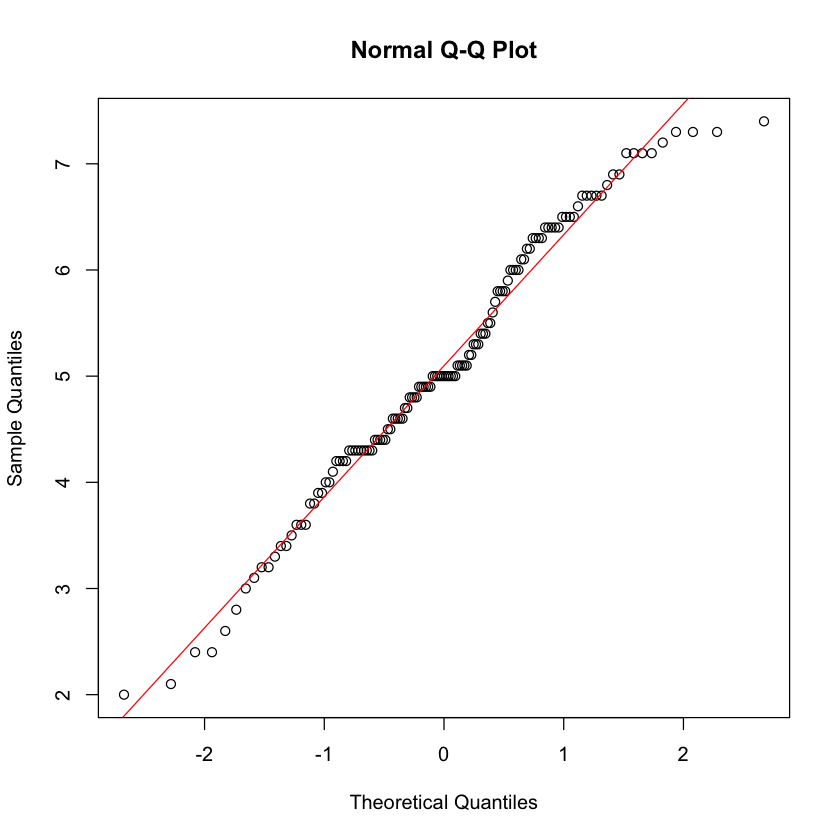

Warning message in chisq.test(df2$Type, df2[, nnn]):
“Chi-squared approximation may be incorrect”

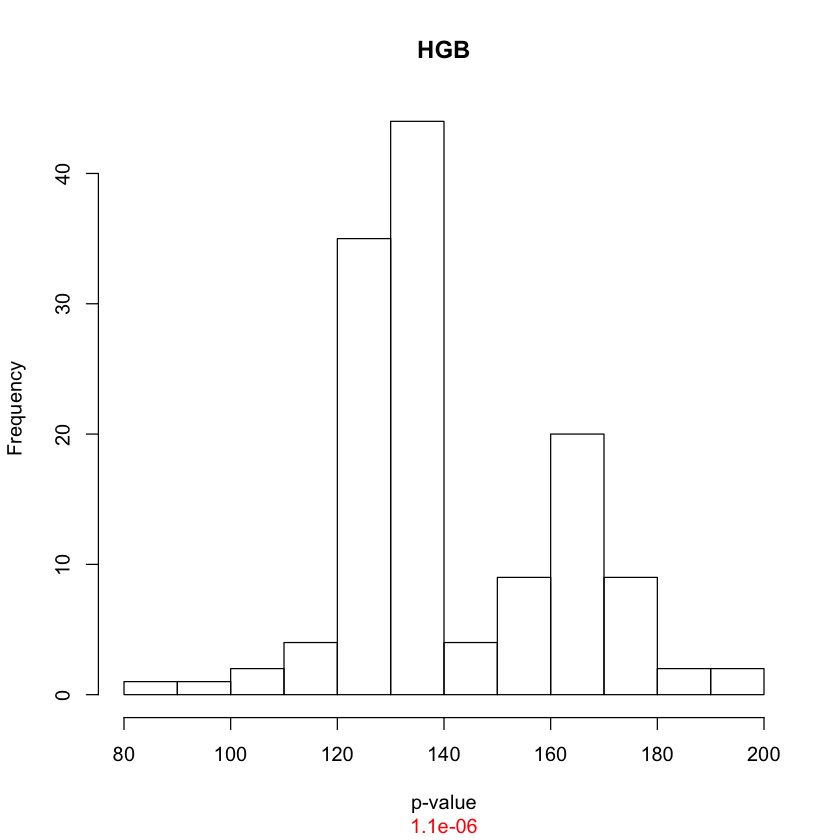

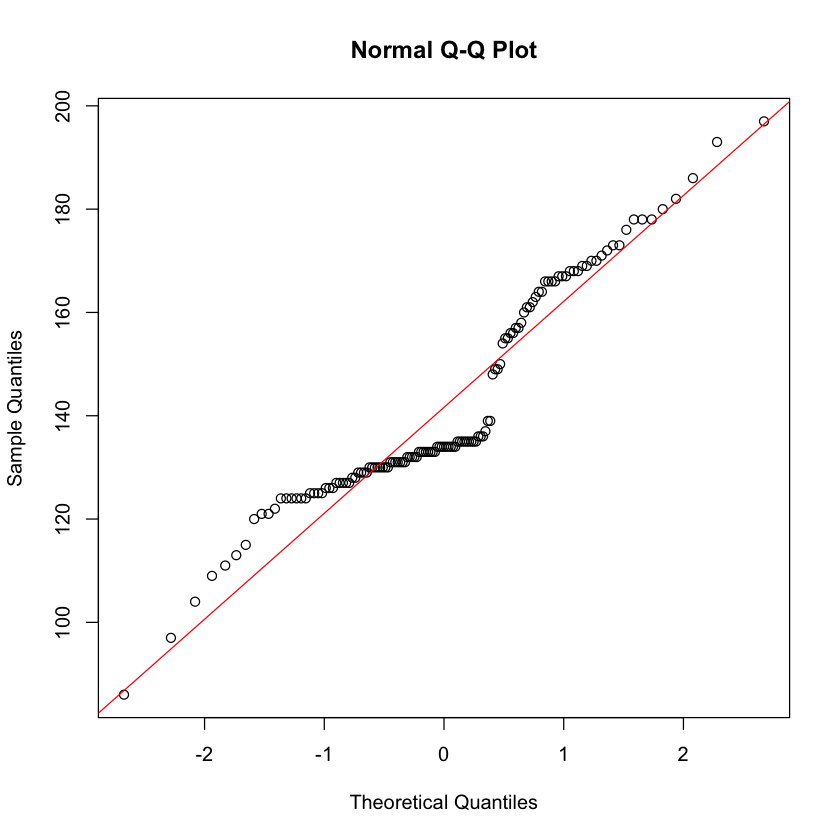

Warning message in chisq.test(df2$Type, df2[, nnn]):
“Chi-squared approximation may be incorrect”

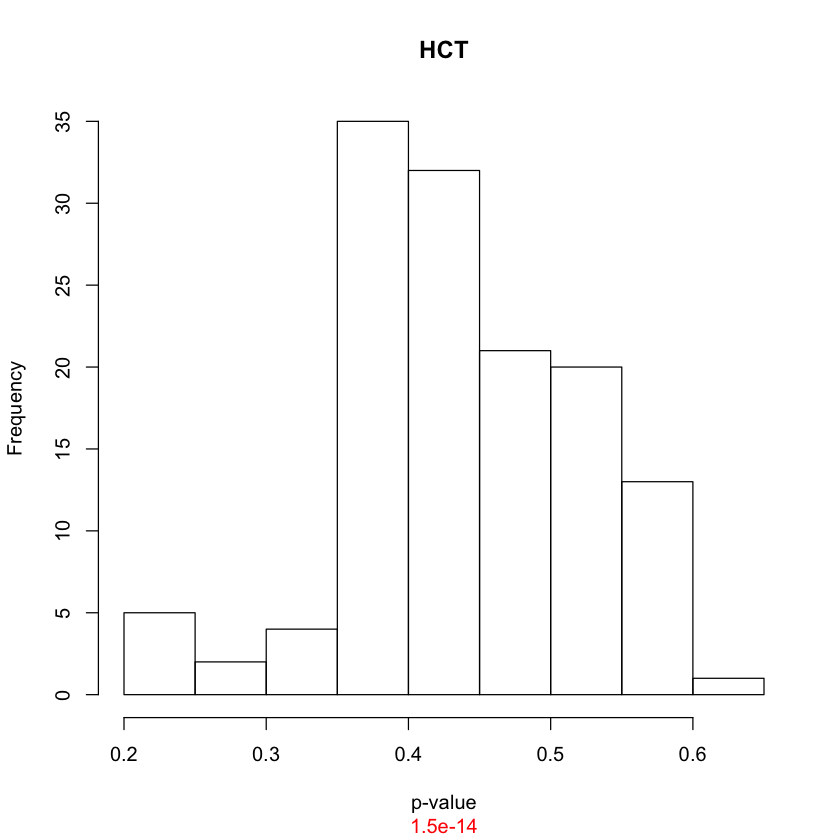

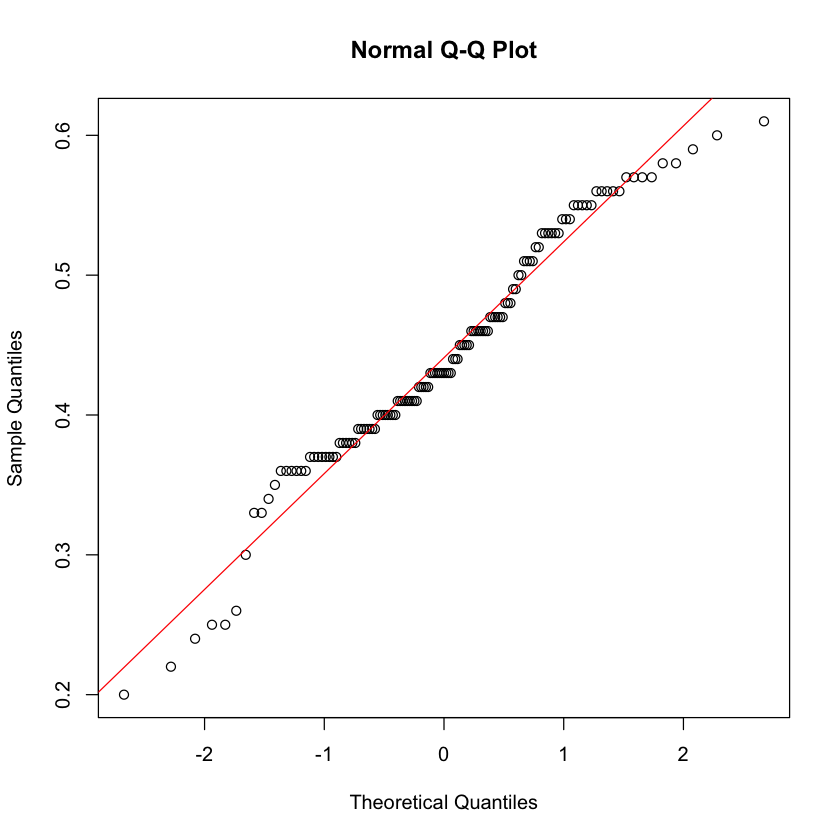

Warning message in chisq.test(df2$Type, df2[, nnn]):
“Chi-squared approximation may be incorrect”

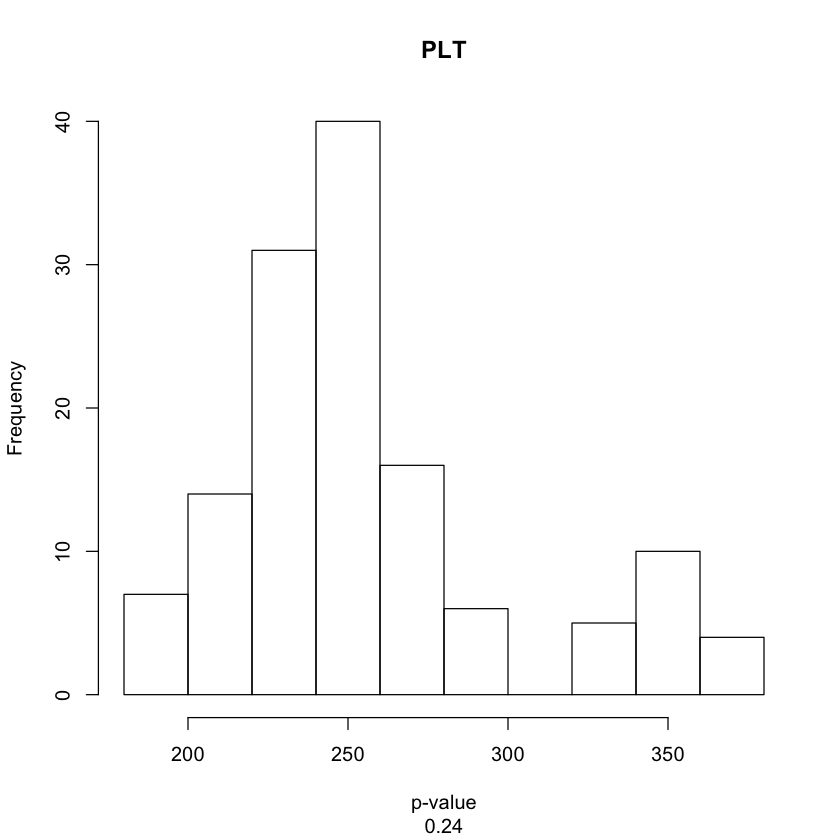

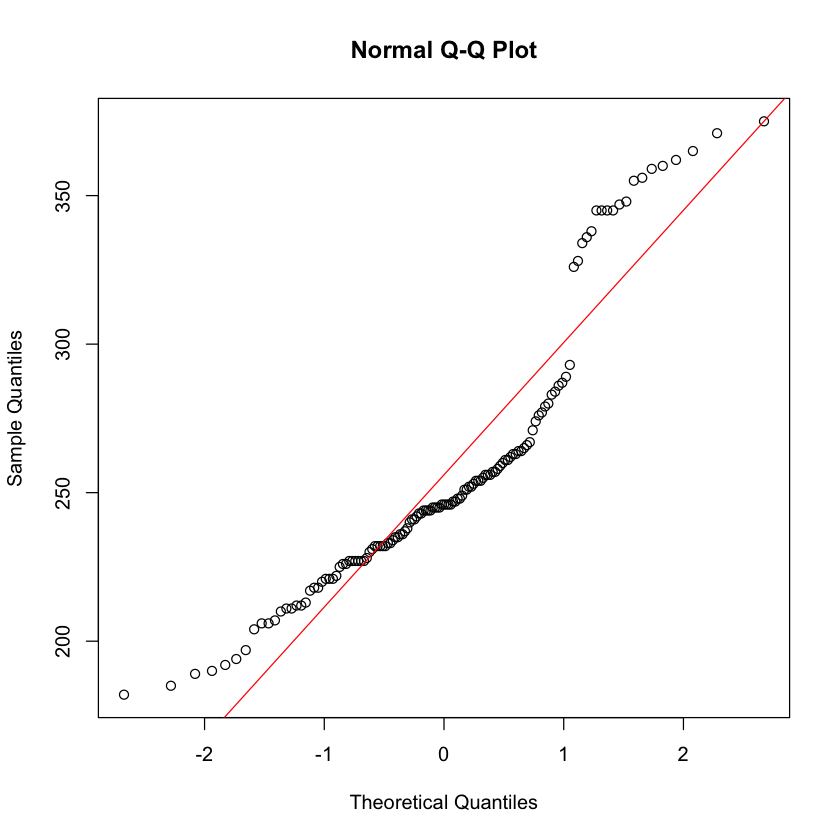

Warning message in chisq.test(df2$Type, df2[, nnn]):
“Chi-squared approximation may be incorrect”

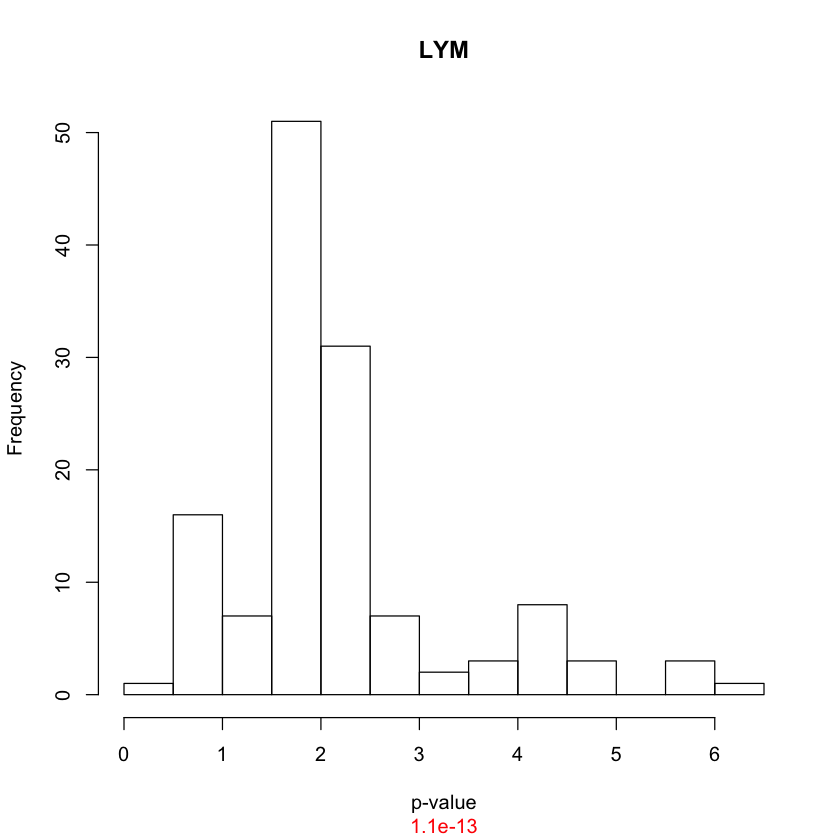

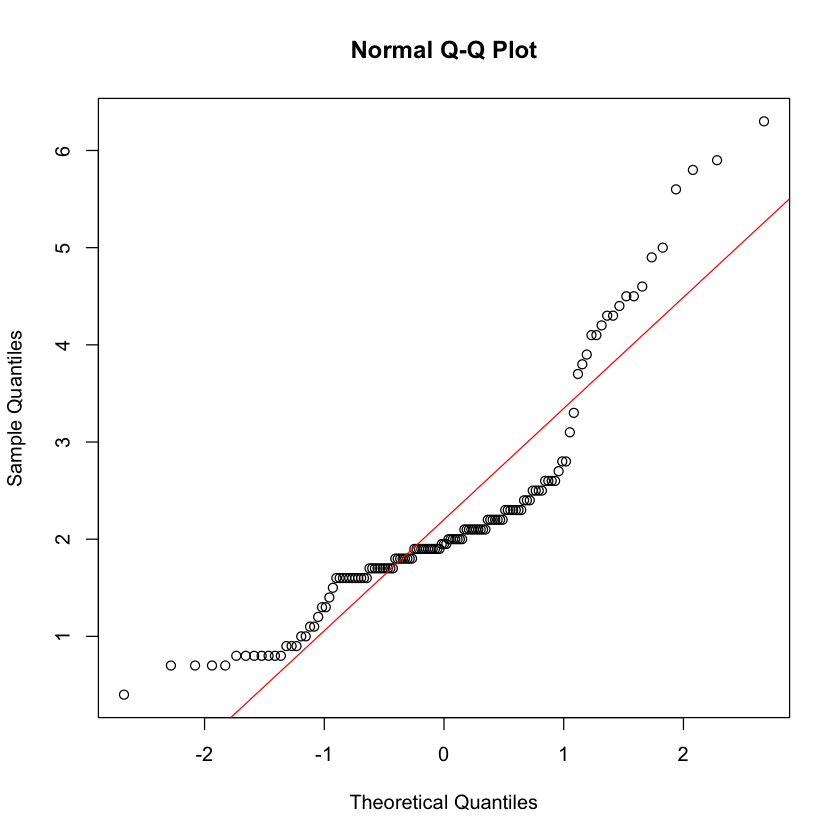

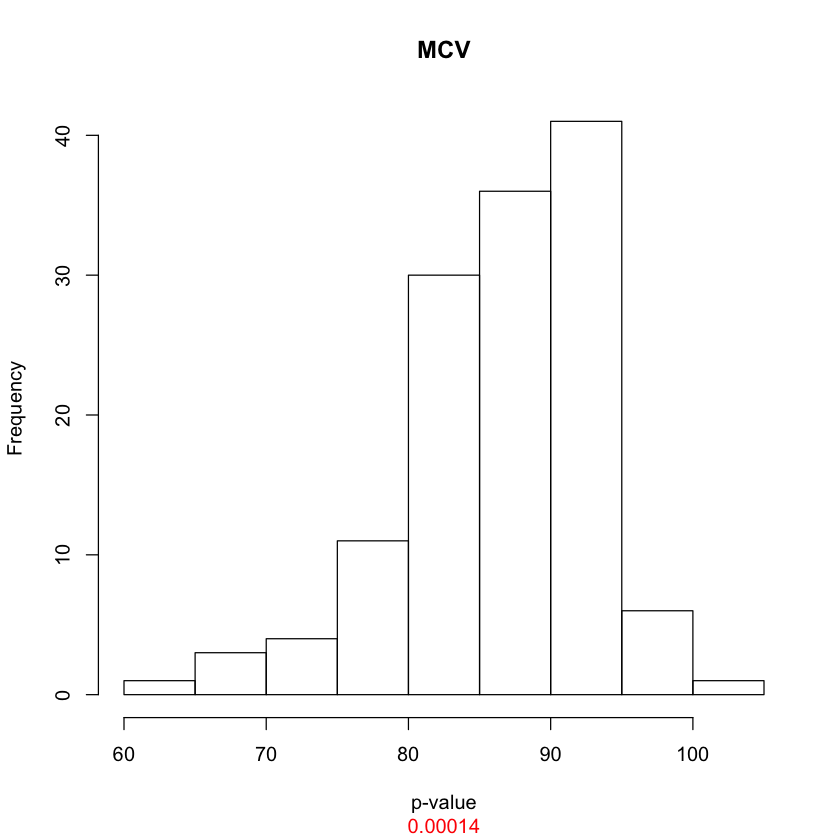

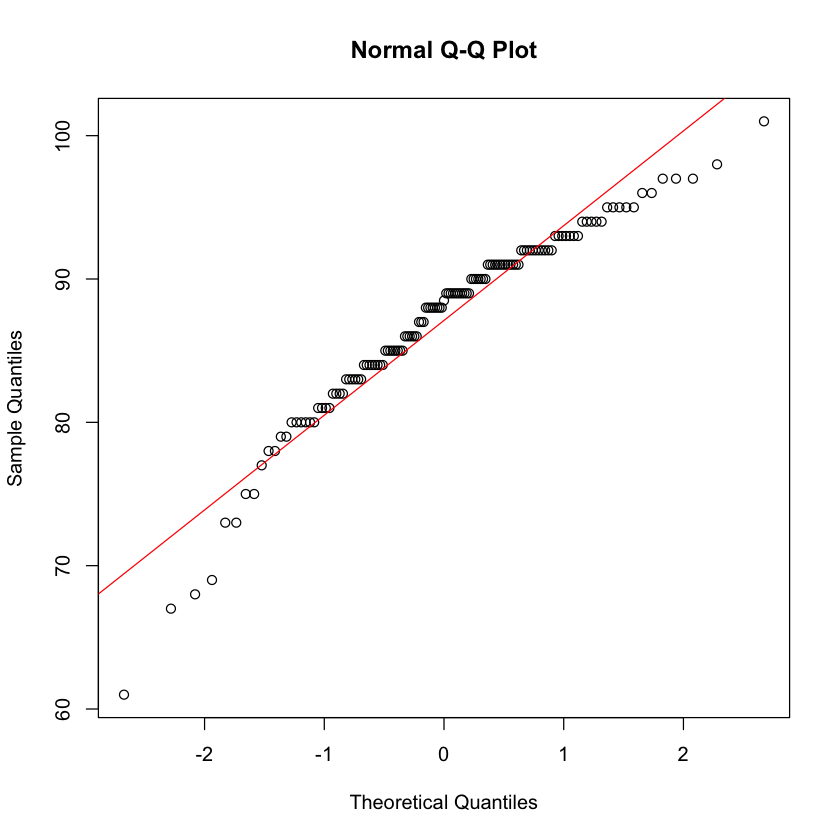

In [22]:
for(nnn in list_names){
  chisq.test(df2$Type, df2[,nnn])$p.value->pv
  hist(df2[, nnn], main=nnn, sub=format(pv, dig=2),
        xlab="p-value", col.sub=1+(pv<0.05))
  qqnorm(df2[, nnn])
  abline(c(mean(df2[, nnn]), sd(df2[, nnn])), col=2)
}

In [1]:
# надо включить питон ядро 
%%writefile Анализ_кровиNA.R
library("openxlsx")

df <- read.xlsx("АнализКровиNA.xlsx", sheet = 11)

# если пропуски 
any(is.na(df))

str(df)

# Используем функцию complete.cases() для получения процента отсутствующих значений
nrow(df[!complete.cases(df), ])/nrow(df)*100

# функция производит замену пропусков
# type может быть  median, mean, min
impute <- function(data, type) {
  for (i in which(sapply(data, is.numeric))) {
    data[is.na(data[, i]), i] <- type(data[, i],  na.rm = TRUE)
  }
  return(data)}

df2 <- impute(df, median)


# остались ли пропуски 
any(is.na(df2))

nums <- unlist(lapply(df2, is.numeric))  
list_names <- colnames(df2[ , nums])[colnames(df2[ , nums]) != "age"]


# загрузим данные с нормами 
normq <- read.xlsx("АнализКровиNA.xlsx", sheet = 3)
colnames(normq)[colnames(normq) == "X1"] <- "gender"
normq


# функция которая вычисляет для каждого пациента и каждого анализа вычислите, выше он нормы, ниже или в пределах
f <- function(df_dan, df_norm){
    nums <- unlist(lapply(df_dan, is.numeric))
    list_names <- colnames(df_dan[ , nums])[colnames(df_dan[ , nums]) != "age"]
    list_normq <- colnames(df_norm)[colnames(df_norm) %in% list_names]

    men <- subset(df_dan, gender == 'male')
    women <- subset(df_dan, gender == 'female')

    y_m <- df_norm[c(1, 3),]
    y_w <- df_norm[c(2, 4),]

    for(r in 1:nrow(men)){
        for(c in list_normq){
            if(men[r, c] >= y_m[1, c] && men[r, c] < y_m[2, c]){
                men[r, c] <- 'mid'
            }else if(men[r, c] < y_m[1, c]){
                    men[r, c] <- 'low'
            }else if(men[r, c] >= y_m[2, c]){
                     men[r, c] <- 'hi'
            }
        }
    }

    for(r in 1:nrow(women)){
        for(c in list_normq){
            if(women[r, c] >= y_w[1, c] && women[r, c] < y_w[2, c] ){
                women[r, c] <- 'mid'
            }else if(women[r, c] < y_w[1, c]){
                    women[r, c] <- 'low'
            }else if(women[r, c] >= y_w[2, c]){
                     women[r, c] <- 'hi'
            }
        }
    }    
    res <- rbind(men, women)
        
    for(c in list_normq){
    res[, c] <- as.factor(res[, c])
}    
    return(res)
}

# новый датафрейм, где указано анализы выше, ниже или в норме 
res <- f(df2, normq)
str(res)
head(res)


# универсальная функция куда мы всталяем наши данные и критерий 
prov <- function(x, y, test, res=c("Отвергаем H_0", "Принимаем H_0"), alfa=0.05) {
    test(x,y)-> test_xy
    cat("Проверяется", test_xy$method,"\n")
    cat("На уровне", format(test_xy$p.value,dig=2),
        res[1+(test_xy$p.value>alfa)],"\n")
}

# Проверим, есть ли взаимосвязь данных с диагнозом ( с помощью критерия хи-квадрат)
x<- as.factor(res$Type)
for(z in list_names){
    cat(z)
    prov(x, res[, z], chisq.test)
    cat('-------------------------------------\n')
}


# Графики
for(nnn in list_names){
  chisq.test(df2$Type, df2[,nnn])$p.value->pv
  hist(df2[, nnn], main=nnn, sub=format(pv, dig=2),
        xlab="p-value", col.sub=1+(pv<0.05))
  qqnorm(df2[, nnn])
  abline(c(mean(df2[, nnn]), sd(df2[, nnn])), col=2)
}



SyntaxError: invalid syntax (<ipython-input-1-0fc49eb67d0c>, line 8)

In [ ]:
# setwd("Documents/R-project/КФУ Анализ данных в R/проверить/var7.csv")
# read.csv2("bloodwork_sheet.csv",stringsAsFactors=TRUE,sep = ",",na.strings=c("","NA"))->data

# setwd("Documents/R-project/КФУ Анализ данных в R/проверить/var7.csv")
data <- read.csv2("Documents/R-project/КФУ Анализ данных в R/проверить/var7.csv", header=TRUE, sep=";", dec=",");
data_ready <- na.omit(data);

norms=read.csv("norms.csv",header=TRUE, sep=";", dec=",");

#если столбец гендера не на своем месте
gender_index = grep("gender", colnames(data_ready))

#сначала для межучин, потом для женщин
#по результатам выдаем "low", "norm", "high"
for (analisys_name in names(data_ready)[4:10]){
  data_ready[data_ready[gender_index]=="male", analisys_name] =
    cut( data_ready[data_ready[gender_index]=="male", analisys_name] ,
         breaks=c(0, as.numeric(norms[1,analisys_name]), as.numeric(norms[3,analisys_name]), Inf),
         labels=c("low", "norm","high"));
  data_ready[data_ready[gender_index]=="female", analisys_name] =
    cut( data_ready[data_ready[gender_index]=="female", analisys_name] ,
         breaks=c(0,as.numeric(norms[2,analisys_name]), as.numeric(norms[4,analisys_name]), Inf),
         labels=c("low", "norm", "high"));
  data_ready[, analisys_name] =
    cut( data_ready[, analisys_name], breaks=c(0, 1, 2, Inf), labels=c("low", "norm","high"))
}
norms = c()
#количество нормальных анализов
for(r in 1:nrow(data_ready)){
  norms = c(norms,norm_count(data_ready[r,], "norm"))  
}
data_ready = cbind(data_ready, norms)

#график "ненормальности анализов" в соответствии с типом заболевания
barplot(tapply(data_ready$norms!=7, data_ready$Type, FUN=sum))
barplot(tapply(data_ready$norms==7, data_ready$Type, FUN=sum))

#строим для анализов, которые ниже нормы(для анализов выше нормы аналогично)
lows = c()
for(r in 1:nrow(data_ready)){
  lows = c(lows,norm_count(data_ready[r,], "low"))  
}
data_ready = cbind(data_ready, lows)
barplot(tapply(data_ready$Type=="Healthy", data_ready$lows, FUN=sum), 
        legend.text = "Сколько анализов ниже при")

barplot(tapply(data_ready$Type=="Healthy", data_ready$counts, FUN=sum), 
        legend.text = "Сколько анализов не в норме при")

#запись в файл
write.csv(data_ready, "C:/Users/pc/Desktop/univer/3kurs/r_course/Data/out_norms.csv", row.names = FALSE)

norm_count <- function(vector, line_str) {
  temp_C <- length(vector[vector[] == line_str])
  return(temp_C)
}

# Черновик 

In [207]:
df_dan <- df2
df_norm <- normq

nums <- unlist(lapply(df_dan, is.numeric))
list_names <- colnames(df_dan[ , nums])[colnames(df_dan[ , nums]) != "age"]
list_normq <- colnames(df_norm)[colnames(df_norm) %in% list_names]

men = subset(df_dan, gender == 'male')
women = subset(df_dan, gender == 'female')

y_m <- df_norm[c(1, 3),]
    
y_w <- df_norm[c(2, 4),]

for(r in 1:nrow(men)){
    for(c in list_normq){
        if(men[r, c] >= y_m[1, c] && men[r, c] < y_m[2, c]){
            men[r, c] <- 'mid'
        }else if(men[r, c] < y_m[1, c]){
                men[r, c] <- 'low'
        }else if(men[r, c] >= y_m[2, c]){
                 men[r, c] <- 'hi'
        }
    }
}

for(r in 1:nrow(women)){
    for(c in list_normq){
        if(women[r, c] >= y_w[1, c] && women[r, c] < y_w[2, c] ){
            women[r, c] <- 'mid'
        }else if(women[r, c] < y_w[1, c]){
                women[r, c] <- 'low'
        }else if(women[r, c] >= y_w[2, c]){
                 women[r, c] <- 'hi'
        }
    }
}    
res <- rbind(men, women)

In [223]:
res[order(as.numeric(rownames(df2))), ]

,sirname,age,gender,WBC,RBC,HGB,HCT,PLT,LYM,MCV,Type
2,Arnold,29,male,mid,mid,mid,mid,mid,mid,mid,Healthy
6,Bishop,50,male,mid,hi,hi,hi,mid,mid,hi,Thrombosis
10,Byrne,38,male,mid,low,mid,mid,mid,low,low,Deficit
11,Byrne,72,male,mid,hi,hi,hi,mid,mid,hi,Thrombosis
14,Carter,37,male,mid,low,low,low,mid,mid,low,Anemia
15,Clark,38,male,hi,mid,mid,low,mid,mid,hi,Healthy
18,Cook,40,male,low,low,mid,mid,hi,hi,hi,Inflammation
20,Cummings,60,male,mid,mid,mid,low,mid,mid,hi,Healthy
22,Day,47,male,mid,mid,mid,mid,mid,mid,hi,Healthy
23,Day,66,male,mid,mid,hi,hi,mid,mid,hi,Thrombosis


In [173]:
list_normq

[1] "WBC" "RBC" "PLT" "LYM" "MCV" "HGB" "HCT"

In [174]:
normq

gender,WBC,RBC,PLT,LYM,GRA,MCV,MCH,HGB,HCT
male,4,4.3,180,1.2,1.2,80,26,120,0.39
female,4,3.8,180,1.2,1.2,80,26,120,0.35
male,9,6.2,320,3.0,6.1,100,35,140,0.49
female,9,5.5,320,3.0,6.1,100,35,140,0.45


In [172]:
head(df2[df2$gender == 'female',])

,sirname,age,gender,WBC,RBC,HGB,HCT,PLT,LYM,MCV,Type
1,Allen,38,female,8.6,4.3,111,0.25,256,1.95,73,Anemia
3,Arnold,43,female,7.5,6.0,148,0.47,189,2.20,88,Thrombosis
4,Baker,34,female,6.8,7.1,171,0.55,211,2.80,88,Thrombosis
5,Becker,19,female,7.4,5.0,122,0.43,221,1.60,95,Healthy
7,Black,45,female,5.2,6.4,169,0.46,254,1.90,86,Thrombosis
8,Brooks,32,female,12.5,4.5,134,0.41,362,3.70,89,Inflammation


In [171]:
head(women)

,sirname,age,gender,WBC,RBC,HGB,HCT,PLT,LYM,MCV,Type
1,Allen,38,female,mid,mid,low,low,mid,mid,low,Anemia
3,Arnold,43,female,mid,hi,hi,hi,mid,mid,hi,Thrombosis
4,Baker,34,female,mid,hi,hi,hi,mid,mid,hi,Thrombosis
5,Becker,19,female,mid,mid,mid,mid,mid,mid,hi,Healthy
7,Black,45,female,mid,hi,hi,hi,mid,mid,hi,Thrombosis
8,Brooks,32,female,low,mid,mid,mid,hi,hi,hi,Inflammation


In [113]:
tail(men)

,sirname,age,gender,WBC,RBC,HGB,HCT,PLT,LYM,MCV,Type
123,Wang,70,male,5.3,mid,mid,mid,243,mid,82,Thrombosis
124,Ward,76,male,6.3,mid,109,0.26,mid,mid,67,Anemia
125,Washington,40,male,6.3,mid,mid,mid,197,mid,80,Thrombosis
127,White,29,male,mid,mid,mid,mid,mid,mid,mid,Thrombosis
128,White,42,male,13.2,mid,126,0.41,mid,mid,mid,Inflammation
132,Wright,39,male,6.6,mid,mid,mid,232,1.8,mid,Thrombosis


In [96]:
tail(df2)

,sirname,age,gender,WBC,RBC,HGB,HCT,PLT,LYM,MCV,Type
128,White,42,male,13.2,4.5,126,0.41,328,4.3,92,Inflammation
129,Williamson,48,female,6.6,4.9,139,0.42,212,1.7,90,Healthy
130,Wilson,44,female,7.9,5.8,180,0.51,279,2.0,83,Thrombosis
131,Wolf,69,female,3.1,2.4,131,0.37,264,0.8,85,Deficit
132,Wright,39,male,6.6,7.3,193,0.53,232,1.8,89,Thrombosis
133,Young,50,female,6.2,4.9,133,0.36,194,1.7,93,Healthy


In [114]:
df2[123, 'WBC'] > normq[1, "WBC" ]

[1] TRUE

In [93]:
findInterval(df2[123, 'LYM'], c(normq[1, 'LYM'], normq[3, 'LYM']))

[1] 1

In [41]:
df2[123, 'MCV'] >=  normq[1, 'MCV'] || df2[129, 'MCV'] <=  normq[3, 'MCV']

[1] TRUE

In [68]:
a <- findInterval(df2[, 'MCV'], c(normq[1, 'MCV'], normq[3, 'MCV']))

In [49]:
df_dan <- df2[1, ]
df_norm <- normq

nums <- unlist(lapply(df_dan, is.numeric))
    list_names <- colnames(df_dan[ , nums])[colnames(df_dan[ , nums]) != "age"]
    list_normq <- colnames(df_norm)[colnames(df_norm) %in% list_names]

    
    for(r in 1:nrow(df_dan)){
        if(df_dan[r, 'gender'] == 'male'){
            y <- df_norm[c(1, 3), ]
        }else{
            y <- df_norm[c(2, 4), ]
        }
        }

In [53]:
y[2,]

,gender,WBC,RBC,PLT,LYM,GRA,MCV,MCH,HGB,HCT
4,female,9,5.5,320,3,6.1,100,35,140,0.45


In [ ]:
                
            }else if( df_dan[r, c] < y[1, c]){
                df_dan[r, c] <- 'low'
            
            }else{
                df_dan[r, c] <- 'mid'

In [ ]:
    
    men = subset(df_norm, gender == 'male')
    women = subset(df_norm, gender == 'female')
    

    y_m <- men[, c(list_normq)]
    y_m <- y_m[ , order(names(y_m))]
    
    y_w <- women[, c(list_normq)]
    y_w <- y_w[ , order(names(y_w))]

In [19]:
df_dan <- df2
df_norm <- normq
nums <- unlist(lapply(df_dan, is.numeric))
    list_names <- colnames(df_dan[ , nums])[colnames(df_dan[ , nums]) != "age"]
    list_normq <- colnames(df_norm)[colnames(df_norm) %in% list_names]
    
    men = subset(df_norm, gender == 'male')
    women = subset(df_norm, gender == 'female')
    
    x <- df_dan[, colnames(df_dan %in% list_normq)]
    x <- x[ , order(names(x))]

    y_m <- men[, c(list_normq)]
    y_m <- y_m[ , order(names(y_m))]
    
    y_w <- women[, c(list_normq)]
    y_w <- y_w[ , order(names(y_w))]
    
    
    
    for(r in 1:nrow(df_dan)){
        if(df_dan[r, 'gender'] == 'male'){
            y <- y_m
        }else{
            y <- y_w
        }
        for(i in list_normq){
            if( df_dan[r, i] < y[1,i]){
                df_dan[r, i] <- 'low'
            
            } else if((df_dan[r, i] >= y[1,i] | df_dan[r, i] <= y[2,i])){
                df_dan[r, i] <- 'mid'
            
            } else if(df_dan[r, i] > y[2,i]){
                df_dan[r, i] <- 'hi'
            }
       }     
    }

In [ ]:
for(r in 1:2){
        if(dan[r, 'gender'] == 'male'){
            y <- y_m
        }else{
            y <- y_w
        }
        for(i in list_normq){
            if( dan[r, i] < y[1,i]){
                dan[r, i] <- 'low'
            
            } else if( dan[r, i] >= y[1,i] || dan[r, i] <= y[2,i] ){
                dan[r, i] <- 'mid'
            
            } else if(dan[r, i] > y[2,i]){
                dan[r, i] <- 'hi'
            }
       }     
    }

In [ ]:
if(df_dan[r, c] >= y[1, c] || df_dan[r, c] <= y[2, c])

In [37]:
y_w[1, 'WBC']  < df2[128, 'WBC']

[1] TRUE

In [38]:
y_m

,HCT,HGB,LYM,MCV,PLT,RBC,WBC
1,0.39,120,1.2,80,180,4.3,4
3,0.49,140,3.0,100,320,6.2,9


In [45]:
tail(df_dan)

,sirname,age,gender,WBC,RBC,HGB,HCT,PLT,LYM,MCV,Type
128,White,42,male,low,mid,mid,mid,mid,mid,mid,Inflammation
129,Williamson,48,female,mid,mid,mid,mid,mid,mid,mid,Healthy
130,Wilson,44,female,mid,mid,mid,mid,mid,mid,mid,Thrombosis
131,Wolf,69,female,low,low,mid,mid,mid,low,mid,Deficit
132,Wright,39,male,mid,mid,mid,mid,mid,mid,mid,Thrombosis
133,Young,50,female,mid,mid,mid,mid,mid,mid,mid,Healthy


In [46]:
tail(df2)

,sirname,age,gender,WBC,RBC,HGB,HCT,PLT,LYM,MCV,Type
128,White,42,male,13.2,4.5,126,0.41,328,4.3,92,Inflammation
129,Williamson,48,female,6.6,4.9,139,0.42,212,1.7,90,Healthy
130,Wilson,44,female,7.9,5.8,180,0.51,279,2.0,83,Thrombosis
131,Wolf,69,female,3.1,2.4,131,0.37,264,0.8,85,Deficit
132,Wright,39,male,6.6,7.3,193,0.53,232,1.8,89,Thrombosis
133,Young,50,female,6.2,4.9,133,0.36,194,1.7,93,Healthy


In [21]:
df2[128, 'WBC']

 num 13.2


In [49]:
df2[1, 'gender']

[1] "female"

In [71]:
dan <- df2[c(1,2), ]
for(r in 1:2){
        if(dan[r, 'gender'] == 'male'){
            y <- y_m
        }else{
            y <- y_w
        }
        for(i in list_normq){
            if( dan[r, i] < y[1,i]){
                dan[r, i] <- 'low'
            
            } else if( dan[r, i] >= y[1,i] || dan[r, i] <= y[2,i] ){
                dan[r, i] <- 'mid'
            
            } else if(dan[r, i] > y[2,i]){
                dan[r, i] <- 'hi'
            }
       }     
    }

In [72]:
dan

sirname,age,gender,WBC,RBC,HGB,HCT,PLT,LYM,MCV,Type
Allen,38,female,mid,mid,low,low,mid,mid,low,Anemia
Arnold,29,male,mid,mid,mid,mid,mid,mid,mid,Healthy


In [40]:
df2[c(1, 2), ]

sirname,age,gender,WBC,RBC,HGB,HCT,PLT,LYM,MCV,Type
Allen,38,female,8.6,4.3,111,0.25,256,1.95,73,Anemia
Arnold,29,male,7.3,4.3,127,0.46,245,1.80,88,Healthy


In [73]:
y_m

,HCT,HGB,LYM,MCV,PLT,RBC,WBC
1,0.39,120,1.2,80,180,4.3,4
3,0.49,140,3.0,100,320,6.2,9


In [70]:
((df2[1, 'MCV'] >= y_w[1, 'MCV']) || (df2[1, 'MCV'] <= y_w[2, 'MCV']))

[1] TRUE

In [86]:
x <- df2[, colnames(df2) %in% list_normq]
x <- x[ , order(names(x))]

y <- men[, c(list_normq)]
y <- y[ , order(names(y))]

In [87]:
for(i in list_normq){
    for(j in 1:nrow(x)){
        if( x[j, i] < y[,i]){
            x[j, i] <- 'low' 
        }else if(x[j, i] > y2[,i]){
            x[j, i] <- 'hi'
        }else if(x[j, i] > y[,i] | x[j, i] < y2[,i]){
            x[j, i] <- 'mid'
        }
    }     
}

In [77]:
head(x)

HCT,HGB,LYM,MCV,PLT,RBC,WBC
0.25,111,1.95,73,256,4.3,8.6
0.46,127,1.80,88,245,4.3,7.3
0.47,148,2.20,88,189,6.0,7.5
0.55,171,2.80,88,211,7.1,6.8
0.43,122,1.60,95,221,5.0,7.4
0.53,163,2.80,83,226,6.5,7.3


In [90]:
head(x)

HCT,HGB,LYM,MCV,PLT,RBC,WBC
low,low,mid,low,mid,mid,mid
mid,mid,mid,hi,mid,mid,mid
mid,hi,mid,hi,mid,mid,mid
hi,hi,mid,hi,mid,hi,mid
mid,mid,mid,hi,mid,mid,mid
hi,hi,mid,hi,mid,hi,mid


In [78]:
tail(x)

,HCT,HGB,LYM,MCV,PLT,RBC,WBC
128,0.41,126,4.3,92,328,4.5,13.2
129,0.42,139,1.7,90,212,4.9,6.6
130,0.51,180,2.0,83,279,5.8,7.9
131,0.37,131,0.8,85,264,2.4,3.1
132,0.53,193,1.8,89,232,7.3,6.6
133,0.36,133,1.7,93,194,4.9,6.2


In [91]:
tail(x)

,HCT,HGB,LYM,MCV,PLT,RBC,WBC
128,mid,mid,hi,hi,hi,mid,low
129,mid,mid,mid,hi,mid,mid,mid
130,hi,hi,mid,hi,mid,mid,mid
131,low,mid,low,hi,mid,low,low
132,hi,hi,mid,hi,mid,hi,mid
133,low,mid,mid,hi,mid,mid,mid


In [104]:
x <- df2[, colnames(df2) %in% list_normq]
x <- x[ , order(names(x))]
y <- men[1, c(list_normq)]
y <- y[ , order(names(y))]


In [105]:
y[ , order(names(y))]

HCT,HGB,LYM,MCV,PLT,RBC,WBC
0.39,120,1.2,80,180,4.3,4


In [106]:
nrow(x)

[1] 133

In [109]:
x[i,] < y

,HCT,HGB,LYM,MCV,PLT,RBC,WBC
133,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [114]:
for(i in 1:nrow(x)){
    cat(i, colnames(x[which(x[i, ] < y)]), ' \n')   
}

1 HCT HGB MCV  
2   
3   
4   
5   
6   
7   
8   
9   
10 LYM RBC  
11   
12   
13 HCT  
14 HCT HGB MCV RBC  
15 HCT  
16 LYM RBC WBC  
17   
18 RBC  
19 LYM RBC WBC  
20 HCT  
21 HCT MCV  
22   
23   
24 RBC  
25 LYM RBC  
26 HCT  
27 HCT HGB MCV  
28 LYM RBC  
29 MCV  
30   
31   
32   
33   
34   
35   
36 HCT RBC  
37   
38   
39   
40   
41 HCT  
42 LYM RBC  
43 HCT  
44   
45   
46   
47 HCT  
48   
49   
50   
51   
52   
53   
54   
55   
56 RBC  
57   
58   
59 RBC WBC  
60   
61 HCT  
62 LYM  
63 HCT  
64 LYM RBC WBC  
65 HCT  
66   
67   
68 HCT LYM RBC WBC  
69   
70   
71 HCT  
72   
73   
74 LYM WBC  
75 RBC  
76   
77   
78 HCT LYM MCV RBC WBC  
79   
80 RBC  
81   
82   
83 HCT HGB MCV RBC  
84 HCT LYM MCV RBC WBC  
85 HCT LYM RBC WBC  
86   
87   
88   
89 RBC  
90 MCV  
91 LYM  
92   
93   
94 MCV  
95   
96 HCT  
97 LYM RBC WBC  
98   
99 RBC  
100   
101 HCT  
102   
103 LYM RBC WBC  
104   
105 HCT RBC  
106   
107   
108   
109   
110   
111 HCT HGB MCV  
112   


In [107]:
for(i in 1:nrow(x)){
    df_s <- subset(x, x[i,] < y)
}

In [108]:
df_s

,HCT,HGB,LYM,MCV,PLT,RBC,WBC
1,0.25,111,1.95,73,256,4.3,8.6
8,0.41,134,3.70,89,362,4.5,12.5
15,0.33,132,1.70,91,249,4.4,9.1
22,0.41,134,2.10,83,227,4.6,5.6
29,0.58,164,1.90,78,221,7.1,7.9
36,0.38,125,2.40,84,289,4.2,6.6
43,0.37,130,1.70,84,232,4.9,7.3
50,0.46,133,2.10,97,236,4.4,7.7
57,0.41,135,3.10,85,345,5.1,13.4
64,0.39,121,0.70,89,248,3.2,2.2


In [91]:
ind <- as.integer(rownames(df_s))


In [78]:
data <- data.frame(norm = character())

In [74]:
xx <- x[ind,]

In [102]:
xx[nrow(xx) + 1,] <- list(c("анализы нижe нормы: ", colnames(x[which(x[8, ] < y)])))

In [100]:
xx$norm <- list(c("анализы нижe нормы: ", colnames(x[which(x[1, ] < y)])))

In [105]:
list(c("анализы нижи нормы: ", colnames(df_s[which(df_s[8, ] < y)])))

[[1]]
[1] "анализы нижи нормы: "

In [103]:
for(i in ind){
cat(colnames(x[which(x[i, ] < y)]),'\n')   
}

HCT HGB MCV 
 
HCT 
 
MCV 
HCT RBC 
HCT 
 
 
LYM RBC WBC 
HCT 
HCT LYM MCV RBC WBC 
HCT LYM RBC WBC 
 
RBC 
 
 
 
 


In [83]:
data <- data.frame(norm = character())    # Create empty data frame

In [254]:
xx

HCT,HGB,LYM,MCV,PLT,RBC,WBC,norm
0.25,111,1.95,73,256,4.3,8.6,"анализы нижи нормы: , HCT , HGB , MCV"


In [165]:
x[1, ] < y

HCT,HGB,LYM,MCV,PLT,RBC,WBC
TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE


In [157]:
x[8, ] < y

,HCT,HGB,LYM,MCV,PLT,RBC,WBC
8,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [158]:
x[15, ] < y

,HCT,HGB,LYM,MCV,PLT,RBC,WBC
15,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [159]:
y

HCT,HGB,LYM,MCV,PLT,RBC,WBC
0.39,120,1.2,80,180,4.3,4


In [160]:
df_s

,HCT,HGB,LYM,MCV,PLT,RBC,WBC
1,0.25,111,1.95,73,256,4.3,8.6
8,0.41,134,3.70,89,362,4.5,12.5
15,0.33,132,1.70,91,249,4.4,9.1
22,0.41,134,2.10,83,227,4.6,5.6
29,0.58,164,1.90,78,221,7.1,7.9
36,0.38,125,2.40,84,289,4.2,6.6
43,0.37,130,1.70,84,232,4.9,7.3
50,0.46,133,2.10,97,236,4.4,7.7
57,0.41,135,3.10,85,345,5.1,13.4
64,0.39,121,0.70,89,248,3.2,2.2
